<a href="https://colab.research.google.com/github/Batsy24/Stonks/blob/main/StonkNet_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Aquisition**


In [54]:
# imports 
!pip install yfinance
!pip install yahoofinancials
!pip install shap
import shap
import yfinance as yf
from yahoofinancials import YahooFinancials
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from datetime import date
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [55]:
# dataset = str(input('Enter the ticker of the stock you would like to use:''\n'))
gs = yf.download('GS', period='max', progress=False)
jpm = yf.download('JPM', period='max', progress=False)
ms = yf.download('MS', period='max', progress=False)
ndaq = yf.download('^IXIC', period='max', progress=False)
nkk = yf.download('^N225', period='max', progress=False)
bse = yf.download('^BSESN', period='max', progress=False)
nya = yf.download('^NYA', period='max', progress=False)


In [56]:
url = 'https://cdn.cboe.com/api/global/us_indices/daily_prices/VIX_History.csv'
vix = pd.read_csv(url, names=['Date', 'Open', 'High', 'Low', 'Close'])
vix = vix.iloc[1: , :]
vix.head()

,Date,Open,High,Low,Close
1,01/02/1990,17.240000,17.240000,17.240000,17.240000
2,01/03/1990,18.190000,18.190000,18.190000,18.190000
3,01/04/1990,19.220000,19.220000,19.220000,19.220000
4,01/05/1990,20.110000,20.110000,20.110000,20.110000
5,01/08/1990,20.260000,20.260000,20.260000,20.260000


## **notes:**
- similar assets being used: 
   - JP morgan chase and morgan stanley (similar companies) 
   - composite indices like NASDAQ and NYSE, BSE and Nikkei225

- volatility index
- technical analysis indicators being used:
    - momentum
    - Moving averages over specified time periods
    - moving averages convergence/divergence
    - Exponential moving averages
    - bollinger bands

- Fundamental analysis: 
   - use google's BERT to perform sentiment analysis on daily news about the company. **[REDACTED]**

   (unfortunately i ran out of time and was not able to impliment the fundamental analysis feature.)


In [57]:
# assets = [gs, ms, jpm, ndaq, nya, vix]
# for asset in assets:
#   print(asset.describe())
#   print(asset.info())
#   print(asset.head(),'\n')

In [58]:
df = gs.copy()

def get_assets(dataframe=df):
  global vix
  dataframe['close ms'] = ms['Close']
  dataframe['close jpm'] = jpm['Close']
  dataframe['close ndaq'] = ndaq['Close']
  dataframe['close nikkei'] = nkk['Close']
  dataframe['close bse'] = bse['Close']
  dataframe['close nya'] = nya['Close']

  vix = vix.set_index(vix['Date'])
  vix = vix.drop('Date', axis=1)
  vix.index = pd.to_datetime(vix.index)
  dataframe.index = pd.to_datetime(dataframe.index)

  dataframe['close vix'] = vix['Close']
  dataframe[['close vix']] = dataframe[['close vix']].apply(pd.to_numeric)

  return dataframe

In [59]:
df = get_assets()
df.head()

,Open,High,Low,Close,Adj Close,Volume,close ms,close jpm,close ndaq,close nikkei,close bse,close nya,close vix
Date,,,,,,,,,,,,,
1999-05-04,76.0000,77.250,70.0000,70.3750,53.576588,22320900,49.03125,54.833332,2485.120117,NaN,3502.949951,6725.950195,25.62
1999-05-05,69.8750,69.875,66.2500,69.1250,52.624954,7565700,49.59375,53.458332,2534.449951,NaN,3557.070068,6772.899902,25.19
1999-05-06,68.0000,69.375,67.0625,67.9375,51.720901,2905700,47.43750,51.708332,2472.280029,17300.609375,3648.860107,6727.220215,27.44
1999-05-07,67.9375,74.875,66.7500,74.1250,56.431465,4862300,50.34375,52.250000,2503.620117,16946.519531,3707.750000,6780.299805,25.36
1999-05-10,73.3750,73.500,70.2500,70.6875,53.814465,2589400,48.93750,52.666668,2526.389893,16977.009766,3820.250000,6760.209961,26.62


## **Technical indicators**

### *1. Moving Averages*
In statistics, a moving average is a calculation used to analyze data points by creating a series of averages of different subsets of the full data set.
By calculating the moving average, the impacts of random, short-term fluctuations on the price of a stock over a specified time frame are mitigated.

The simple moving average is defined by the following equation:


\begin{align}
        \ SMA = \frac{A_1 + A_2+ A_3...A_n}{n} 
    \end{align}

Where $A_n$ is the average in time period $n$

and $n$ is the number of time periods

\
### *2. Exponential Moving Averages*
An exponential moving average is a type of moving average that places a greater weight and significance on the most recent data points.

Exponential moving average is defined by the following formula:

\begin{align}
        \ EMA_{today} = \left(Value_{today} \left(\frac{smoothing}{1+Days}\right)\right) + EMA_{yesterday}\left(1- \left(\frac{smoothing}{1+Days}\right)\right)
    \end{align}

where $smoothing$ is a variable value, it is directly proportional to how much weight recent observations are given

The 12- and 26-day exponential moving averages (EMAs) are often the most quoted and analyzed short-term averages. The 12- and 26-day are used to create indicators like the moving average convergence divergence. 

\
### *3.MACD (moving averages convergence and divergence)*
Moving average convergence divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.

The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.

\begin{align}
        \ EMA_{12 period} - EMA_{26 period}
    \end{align}

The result of that calculation is the MACD line. A nine-day EMA of the MACD called the "signal line," is then plotted on top of the MACD line, which can function as a trigger for buy and sell signals. Traders may buy the security when the MACD crosses above its signal line and sell—or short—the security when the MACD crosses below the signal line.

\
### *4.Momentum*
Momentum indicators are technical analysis tools used to determine the strength or weakness of a stock's price. Momentum measures the rate of the rise or fall of stock prices. Common momentum indicators include the relative strength index (RSI) and moving average convergence divergence (MACD).

### *5. Bollinger Bands*
A Bollinger Band® is a technical analysis tool defined by a set of trendlines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of a security's price. They are computed in the following way: 

\begin{align}
        \ BAND_{upper} = MA\ (TP, n) + mσ\ [TP, n]
    \end{align}
\begin{align}
        \ BAND_{lower} = MA\ (TP, n) - mσ\ [TP, n]
    \end{align}

where $MA$ is the moving average usually taken of around 20 days, $n$ is number of days in a smoothing period (usually 20), $m$ is number of standard deviations (usually 2), $TP$ is a value called the typical price and is given by 

\begin{align}
        \ TP = \frac{(high + low + close)}{3}
    \end{align}

and $mσ\ [TP, n]$ is the standard deviation of n periods of TP 


In [60]:
# a large part of the code in this cell is borrowed from Boris Banushev's work, check bibliographyfor details. 
def get_technical_indicators(dataset=df):

  dataset['ma20'] = dataset['Close'].rolling(window=20).mean()
  dataset['ma200'] = dataset['Close'].rolling(window=200).mean() 

  dataset['26ema'] = dataset['Close'].ewm(span=26, adjust=False).mean()
  dataset['12ema'] = dataset['Close'].ewm(span=12, adjust=False).mean()
  dataset['MACD'] = (dataset['12ema']-dataset['26ema']) # MACD
  dataset['signal_line'] = dataset['MACD'].ewm(span=9, adjust=False).mean()

  dataset['ema'] = dataset['Close'].ewm(com=0.5).mean() # EMA

  dataset['momentum'] = dataset['Close']-1 # Momentum

  dataset['TP'] = (dataset['Close'] + dataset['Low'] + dataset['High'])/3
  dataset['std'] = dataset['TP'].rolling(20).std(ddof=0)
  dataset['MA-TP'] = dataset['TP'].rolling(20).mean()
  dataset['BOLU'] = dataset['MA-TP'] + 2*dataset['std']
  dataset['BOLD'] = dataset['MA-TP'] - 2*dataset['std']

  dataset = dataset.drop('TP', axis=1)
  dataset = dataset.drop('MA-TP', axis=1)
  dataset = dataset.drop('std', axis=1)

  return dataset

In [61]:
df = get_technical_indicators()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5753 entries, 1999-05-04 to 2022-03-11
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5753 non-null   float64
 1   High          5753 non-null   float64
 2   Low           5753 non-null   float64
 3   Close         5753 non-null   float64
 4   Adj Close     5753 non-null   float64
 5   Volume        5753 non-null   int64  
 6   close ms      5753 non-null   float64
 7   close jpm     5753 non-null   float64
 8   close ndaq    5753 non-null   float64
 9   close nikkei  5413 non-null   float64
 10  close bse     5486 non-null   float64
 11  close nya     5753 non-null   float64
 12  close vix     5750 non-null   float64
 13  ma20          5734 non-null   float64
 14  ma200         5554 non-null   float64
 15  26ema         5753 non-null   float64
 16  12ema         5753 non-null   float64
 17  MACD          5753 non-null   float64
 18  signal_lin

In [62]:
mean_nkk = df['close nikkei'].mean()
mean_bse = df['close bse'].mean()
mean_vix = df['close vix'].mean()
mean_bolu = df['BOLU'].mean()
mean_bold = df['BOLD'].mean()

mean_list = [mean_nkk, mean_bse, mean_vix, mean_bolu, mean_bold] #, mean_ma7, mean_ma21]
incomplete_cols = ['close nikkei', 'close bse', 'close vix', 'BOLU', 'BOLD'] #, 'ma7', 'ma21']
n = 0

for mean in mean_list:
  df[incomplete_cols[n]].fillna(value=mean, inplace=True)
  n+=1

df['ma200'] = df['ma200'].fillna(0)
df['ma20'] = df['ma20'].fillna(0)

# **Data Analysis and Exploration**

In [63]:
print(df.info())
print(df.head())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5753 entries, 1999-05-04 to 2022-03-11
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5753 non-null   float64
 1   High          5753 non-null   float64
 2   Low           5753 non-null   float64
 3   Close         5753 non-null   float64
 4   Adj Close     5753 non-null   float64
 5   Volume        5753 non-null   int64  
 6   close ms      5753 non-null   float64
 7   close jpm     5753 non-null   float64
 8   close ndaq    5753 non-null   float64
 9   close nikkei  5753 non-null   float64
 10  close bse     5753 non-null   float64
 11  close nya     5753 non-null   float64
 12  close vix     5753 non-null   float64
 13  ma20          5753 non-null   float64
 14  ma200         5753 non-null   float64
 15  26ema         5753 non-null   float64
 16  12ema         5753 non-null   float64
 17  MACD          5753 non-null   float64
 18  signal_lin

In [64]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,close ms,close jpm,close ndaq,close nikkei,...,ma20,ma200,26ema,12ema,MACD,signal_line,ema,momentum,BOLU,BOLD
Date,,,,,,,,,,,,,,,,,,,,,
1999-05-04,76.0000,77.250,70.0000,70.3750,53.576588,22320900,49.03125,54.833332,2485.120117,15454.171394,...,0.0,0.0,70.375000,70.375000,0.000000,0.000000,70.375000,69.3750,169.733205,150.870827
1999-05-05,69.8750,69.875,66.2500,69.1250,52.624954,7565700,49.59375,53.458332,2534.449951,15454.171394,...,0.0,0.0,70.282407,70.182692,-0.099715,-0.019943,69.437500,68.1250,169.733205,150.870827
1999-05-06,68.0000,69.375,67.0625,67.9375,51.720901,2905700,47.43750,51.708332,2472.280029,17300.609375,...,0.0,0.0,70.108711,69.837278,-0.271432,-0.070241,68.399038,66.9375,169.733205,150.870827
1999-05-07,67.9375,74.875,66.7500,74.1250,56.431465,4862300,50.34375,52.250000,2503.620117,16946.519531,...,0.0,0.0,70.406213,70.496928,0.090714,-0.038050,72.264062,73.1250,169.733205,150.870827
1999-05-10,73.3750,73.500,70.2500,70.6875,53.814465,2589400,48.93750,52.666668,2526.389893,16977.009766,...,0.0,0.0,70.427050,70.526246,0.099197,-0.010601,71.208678,69.6875,169.733205,150.870827


In [65]:
# visualising technical indicators
# a small part of the code below is borrowed from Boris Banushev, check bibliography for more details. 

def plot_technical_indicators(dataset=df, last_days=5700):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma200'],label='MA 200', color='r',linestyle='--')
    plt.plot(dataset['ma20'],label='MA 21', color='b',linestyle='--')

    plt.plot(dataset['BOLU'],label='Upper Band', color='c')
    plt.plot(dataset['BOLD'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['BOLD'], dataset['BOLU'], alpha=0.35)

    plt.plot(dataset['Close'],label='Closing Price', color='b', alpha=0.25)
    plt.title(f'Technical indicators for Goldman Sachs - last {last_days} days.')
    plt.ylabel('USD')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(dataset['close vix'], label='VIX', color='b', alpha=0.5)
    plt.plot(dataset['Close'], label='Closing price', color='r')
    plt.title('Volatility index against prices')
    plt.legend()
    
    plt.show()


def plot_MACD_signal_line(dataset, last_days):
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    dataset[['MACD', 'signal_line']].plot(figsize=(16, 8))
    dataset['Close'].plot(label='Closing Price', alpha=0.25, secondary_y=True)
    plt.title('MACD and Signal')

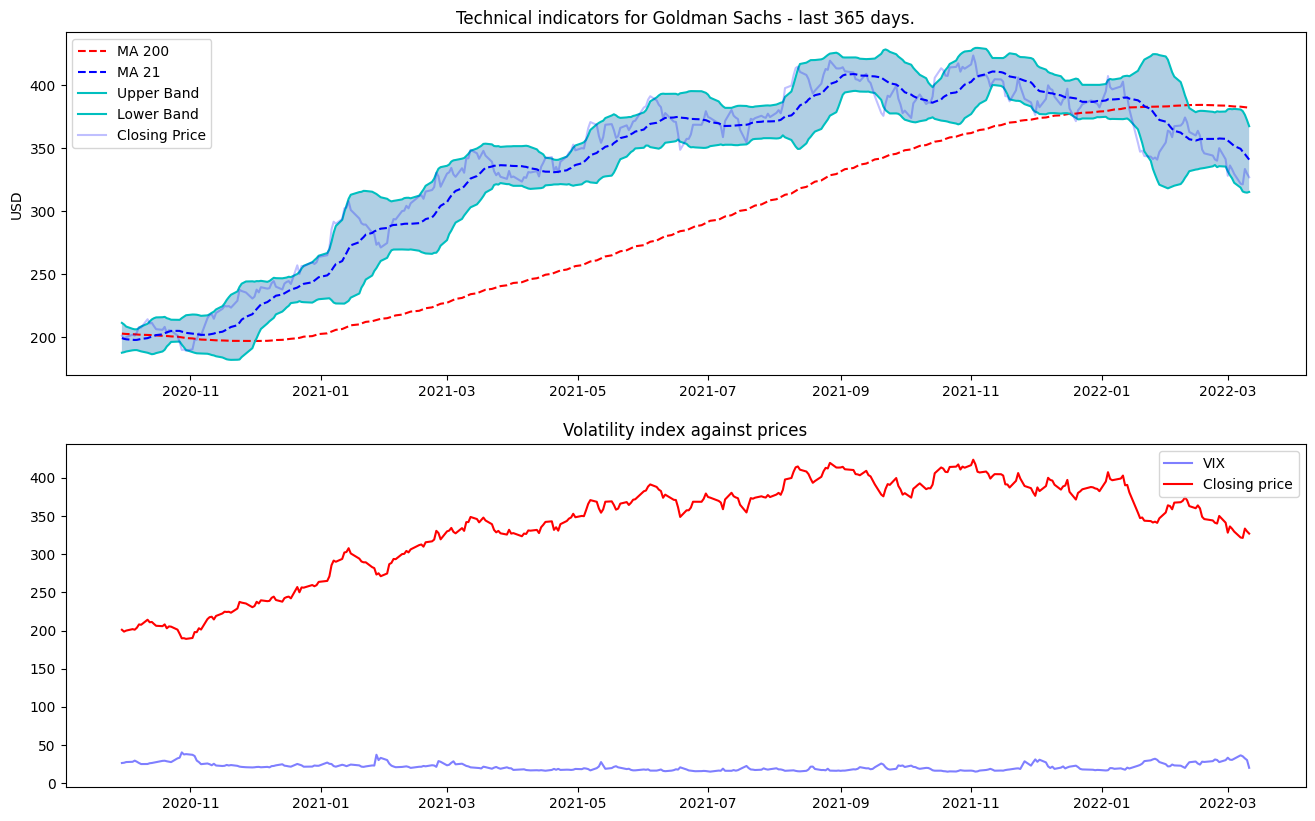

In [66]:
plot_technical_indicators(last_days=365)

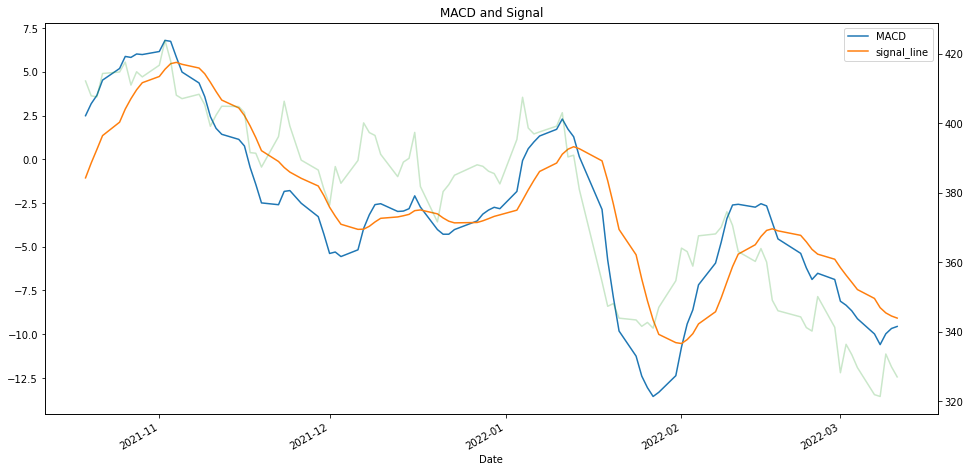

In [67]:
plot_MACD_signal_line(df, 100)

##  *Fourier transform and the FFT*

Any wave varying with time or any wave *in the time domain* is called a time signal. any such signal can be represented as a linear combination of sines and cosines of varying frequencies $f_n$ and amplitudes $A_n$ and $B_n$:


\begin{align}
        \ y(t) = \sum_{n}(A_n \sin(2\pi f_nt) + B_n\cos(2\pi f_nt))
    \end{align}

The Fourier transform, given by:

\begin{align}
        \ \hat{g}(f)= \int_{-\infty}^\infty \mathrm{e}^{-2\pi ift} \ \mathrm{dt}
    \end{align}

lets you see the signal in the *frequency domain* where each frequency that the original signal was comprised of is represented by a spike in the plot. 

An explanation of how this exactly works and how we get the formula for the fourier transform can be found in this video:
https://www.youtube.com/watch?v=spUNpyF58BY 

The FFT or The Fast Fourier Transform does the same thing but it is more computing efficient. an explanation of how that works can be found here: 
https://medium.com/swlh/the-fast-fourier-transform-fft-5e96cf637c38

in this case, since theres no seasonality or periodicity in stocks, I'll be using the FFT and inverse FFT to denoise the data and get a combination of sines and cosines as the resulting graph. we can use this graph to analyse long term trends in the data over specific windows 

in the code below you can observe how as the components of the FFT are increased, the graph starts to resemble the original graph more. thus you can infer that the FFT with 3 components represents long term trends in our data.



In [68]:
# Fourier Transfrom LETSGOOOOO whooooo
df['Date'] = df.index
data = {'Date': df['Date'].tolist(),
        'Prices': df['Close'].tolist()}
df_ = pd.DataFrame(data)
df_.Date = pd.to_datetime(df_.Date)
fft = tf.signal.fft(np.asarray(df_['Prices'].tolist()))
fft_df = pd.DataFrame({'fft':fft})
fft_df['abs'] = np.abs(fft_df['fft'])
df = df.drop('Date', axis=1)
fft_df.head()

,fft,abs
0,923146.25000000-0.42717700j,923146.250000
1,40562.988281+130411.960938j,136574.656250
2,16640.599609+144672.062500j,145625.937500
3,66588.992188+23250.507812j,70531.414062
4,17839.353516+30725.822266j,35529.125000


In [69]:
def plot_trends_fft(dataframe=fft_df):
  global df_
  plt.figure(figsize=(20, 9))
  fft_list = np.asarray(dataframe['fft'].tolist())
  for num_ in [3, 6, 9, 50, 100]:
      fft_list_= np.copy(fft_list)
      fft_list_[num_:-num_] = 0
      inverse_fft = np.abs(tf.signal.ifft(fft_list_))
      plt.plot(inverse_fft, label=f'Fourier transform with {num_} components')

      # inverse_fft_arr = inverse_fft.numpy()
      if num_ == 3:
          df['long term'] = inverse_fft.tolist()
      elif num_ == 9:
          df['medium term'] = inverse_fft.tolist()
          
  plt.plot(df_.Prices, label='Real', alpha=0.5)
  plt.xlabel('Days')
  plt.ylabel('Price')
  plt.title('Fourier transforms and GS (Closing) prices')
  plt.legend()
  plt.show()

  # getting the absolute value of the ifft does not affect the graph, im so stupid 

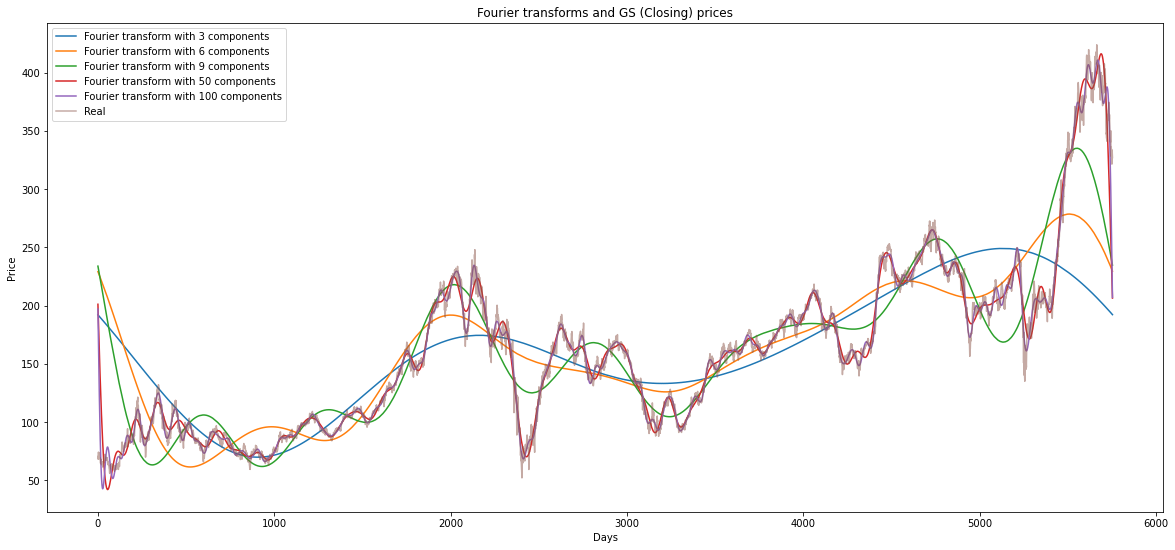

In [70]:
plot_trends_fft()

# **Data Preparation**

In [71]:
# Normalizing the data

dates = df.index.to_list()
df_index = df.index
columns = df.columns.tolist()

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df)
df_scaled_pd = pd.DataFrame(df_scaled, index=df_index, columns=columns)

In [72]:
# Train Test Val split, (70%, 20%, 10%)

n = len(df_scaled_pd)
train_df = df_scaled_pd[0:int(n*0.7)]
val_df = df_scaled_pd[int(n*0.7):int(n*0.9)]
test_df = df_scaled_pd[int(n*0.9):]

num_features = df_scaled_pd.shape[1]
print(num_features)

25


In [73]:
# This Code Is A Metaphor For My Insecurities
# train_df.to_numpy()
# X = train_df
# max = 1
# min = 0
# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min
# print(X_scaled)

In [74]:
print(f'{train_df.shape}, {val_df.shape}, {test_df.shape}')

(4027, 25), (1150, 25), (576, 25)


In [75]:
# print(train_df.info(), val_df.info(), test_df.info())

## **Data Windowing**

In [76]:
# a large part of the following class and some of its methods was borrowed 
# from Tensorflow's official website. refer bibliography for details

class WindowGenerator():
  def __init__(self, input_width: int, label_width: int, offset: int, 
               train_df=train_df, val_df=val_df, test_df=test_df,
               final_df=df_scaled_pd,
               label_columns=None):
    
    # assertions 
    assert input_width > 0, "Input width must be a positive number!" 
    assert label_width > 0, "Label width must be a positive number!" 
    assert offset > 0, "Offset value must be a positive number!" 


    # DATAFRAMES
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.final_df = final_df

    # giving indices to every column in label_columns (in this model there'll only be one label_column)
    # and to every column in the dataset
    self.label_columns = label_columns
    if label_columns is not None:
       self.label_column_indices = {name: i for i, name in enumerate(label_columns)} 
      
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # WINDOW PARAMETERS.

      # input parameters
    self.input_width = input_width
    self.label_width = label_width
    self.offset = offset
    self.total_window_width = input_width + offset

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_width)[self.input_slice]

       # label parameters
    self.label_start = self.total_window_width - self.label_width
    self.label_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_width)[self.label_slice]
  

  def split_window(self, features):
    #(3, 7, 23)
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.label_slice, :]
    if self.label_columns is not None:
      labels = tf.stack([labels[:,:, self.column_indices[name]]for name in 
                         self.label_columns], axis=-1)
      
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_width}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}',
        f'{self.label_column_indices}'])

In [77]:
# test window
wt = WindowGenerator(input_width=5, label_width=1, offset=2,
                     label_columns=['Close'])
wt

Total window size: 7
Input indices: [0 1 2 3 4]
Label indices: [6]
Label column name(s): ['Close']
{'Close': 0}

### This is a visualisation of the test window created above.
I'll be passing data in windows like this where every index correponds to a time step in the data. So the test window has takes in 5 days of data and predicts the time step 2 days after that point.  

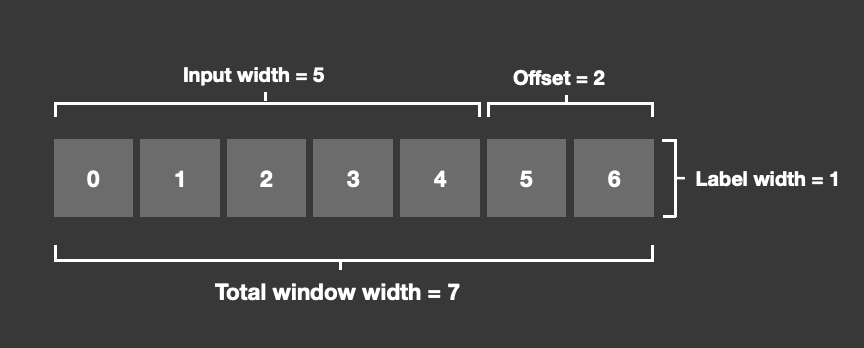

In [78]:
w2 = WindowGenerator(input_width=6, label_width=1, offset=1,
                     label_columns=['Close'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Close']
{'Close': 0}

In [79]:
example_window = tf.stack([np.array(train_df[:w2.total_window_width]),
                           np.array(train_df[100:100+w2.total_window_width]),
                           np.array(train_df[200:200+w2.total_window_width])])


example_inputs, example_labels = w2.split_window(example_window)
w2.example = example_inputs, example_labels
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 25)
Inputs shape: (3, 6, 25)
Labels shape: (3, 1, 1)


In [80]:
def plot(self, model=None, plot_col='Close', max_subplots=3, scatter=False):

  inputs, labels = self.example
  # (32, 6, 25), (32, 1, 1)
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col] # pulls index for col from dict 
  num_plots = min(max_subplots, len(inputs)) 
  for n in range(num_plots): # assume n=3
    plt.subplot(num_plots, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]') # (batch, time,  features)
    # plt.plot(self.input_indices, inputs[n, :, plot_col_index], 
    #          label='Inputs', zorder=-10)

    
    # inputs[n,:,plot_col_index]
    # input shape is (32,6,25) for w2 that is 32 batches, 6 time steps, 25 features

    # n selects the index of list from 32 so that goes from 0 to 3 in most cases

    # : just selects everything in those lists that were just selected, the next index will affect all of 
    
    # this affects all the 6 lists inside whichever list is selected in step 1, in each of the 6 lists
    # there are 25 values corresponding to each of the 25 features we have, plot_col_index is the index for the label col
    # so this will pick only the label values from the list and return those. but that can be changed if you change the plot col param



    if self.label_columns:
      label_col_index = self.label_column_indices.get(plot_col, None) 
      # if we've specified a label col, so this is always true for us and else never runs
      # so this returns the index for our plot column although since we're predicting one value, that'll always be 0
    else:
      label_col_index = plot_col_index # never runs for me lmao

    if label_col_index is None: # if theres no value for plot_col, it returns none however idk why this code was necessary lol
      continue

    if scatter:
      plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    else:
      plt.plot(self.label_indices, labels[n, :, label_col_index],
                 label='Labels', c='g', alpha=0.25)
      
    # both the statements above plot the same thing with different formatting, i wrote that in so
    # labels[n,:,plot_col_index], labels.shape = (32,1,1)
    # simple enough, labels has 32 lists with one list in each with one element in each. n selects lists from index 0-3
    # from the 32 lists, 

    # : selects all the lists in each of the lists we just selected which is just one list in each 

    # since plot_col_index is always 0 for us we get the single element in all those lists with this.
    
    # what we plot are the corresponding labels to the inputs we plotted, however since we're plotting the same value
    # this doesnt matter much. its basically the one dot after all the lines


    if model: 
      predictions = model(inputs) # you can.. call the model.. like a function... i didnt know that..
      if scatter:
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
      else: 
        plt.plot(self.label_indices, predictions[n, :, label_col_index],
                    label='Predictions',
                    c='r')
      

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')

WindowGenerator.plot = plot

In [81]:
# figuring out how tensor indexing works 
tens = tf.constant(
    [
     [[1,2,3,4,5],[1,2,3,4,5]],
     [[3,4,5,8,9],[9,8,5,4,3]], 
     [[6,7,1,2,3],[3,2,1,7,6]]
     ]
)

print(tens.shape)
sliced= tens[0,:,2]
print(sliced)

(3, 2, 5)
tf.Tensor([3 3], shape=(2,), dtype=int32)


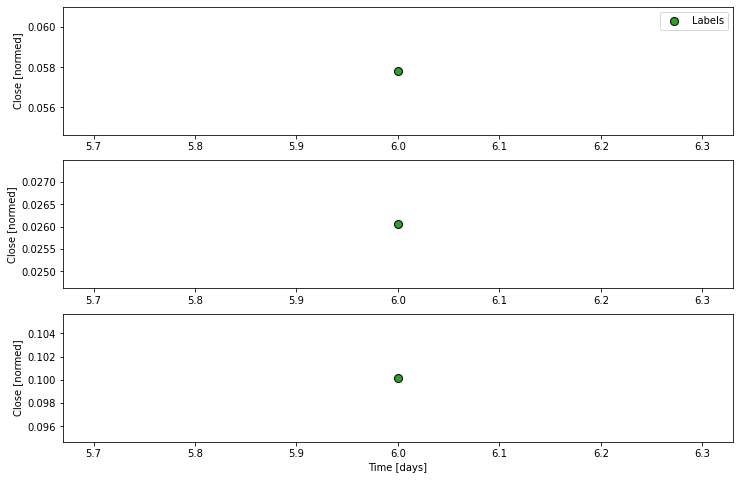

In [82]:
w2.plot(scatter=True)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5753 entries, 1999-05-04 to 2022-03-11
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5753 non-null   float64
 1   High          5753 non-null   float64
 2   Low           5753 non-null   float64
 3   Close         5753 non-null   float64
 4   Adj Close     5753 non-null   float64
 5   Volume        5753 non-null   int64  
 6   close ms      5753 non-null   float64
 7   close jpm     5753 non-null   float64
 8   close ndaq    5753 non-null   float64
 9   close nikkei  5753 non-null   float64
 10  close bse     5753 non-null   float64
 11  close nya     5753 non-null   float64
 12  close vix     5753 non-null   float64
 13  ma20          5753 non-null   float64
 14  ma200         5753 non-null   float64
 15  26ema         5753 non-null   float64
 16  12ema         5753 non-null   float64
 17  MACD          5753 non-null   float64
 18  signal_lin

In [84]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_width,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [85]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def final(self):
  return self.make_dataset(self.final_df)

@property
def example(self):
  #Get and cache an example batch of `inputs, labels` for plotting.
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.final = final
WindowGenerator.example = example


In [86]:
w2.example[0].shape

TensorShape([32, 6, 25])

In [87]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 25), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

# **Modelling**




In [88]:
epochs = 50

def compile_and_fit(model, window, patience=15):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    # baseline = 0.00025097100296989083,
                                                    restore_best_weights=True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.final, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  
  return history

In [89]:
l1 = tf.keras.regularizers.l1(l1=0.001)

lstm_model = tf.keras.models.Sequential([
    # Shape[batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features] 
    tf.keras.layers.Dense(units=1)
])


val_performance = {}
performance = {}

In [90]:
wide_window = WindowGenerator(
    input_width=150, label_width=150, offset=1,
    label_columns=['Close'])

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

history = compile_and_fit(lstm_model, wide_window)

In [92]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

32/32 [==============================] - 1s 13ms/step - loss: 7.2336e-05 - mean_absolute_error: 0.0063


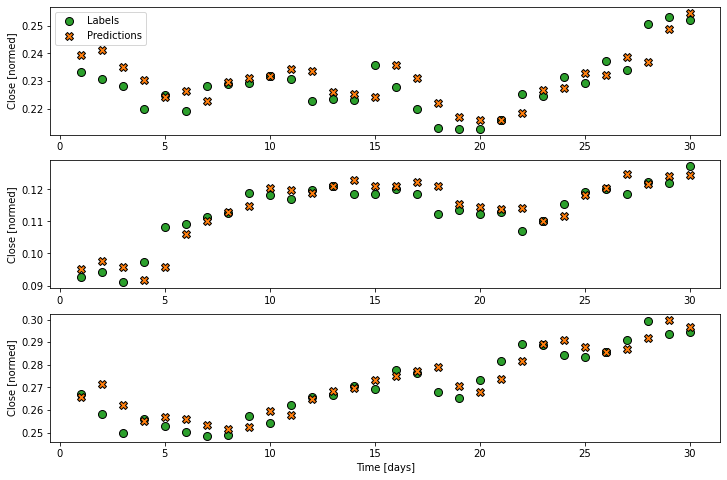

In [93]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, offset=1,
    label_columns=['Close'])
wide_window.plot(lstm_model, scatter=True)

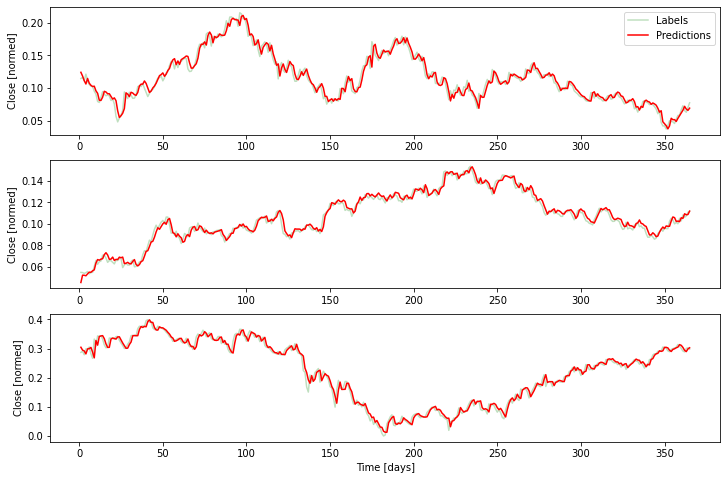

In [94]:
wide_window = WindowGenerator(
    input_width=365, label_width=365, offset=1,
    label_columns=['Close'])
wide_window.plot(lstm_model)

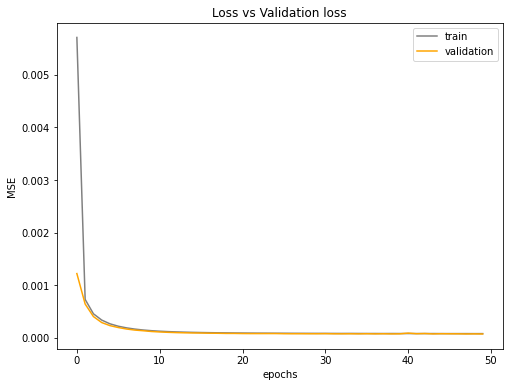

In [95]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
plt.plot(loss, label='train', c='gray')
plt.plot(val_loss, label='validation', c='orange')
plt.title('Loss vs Validation loss')
plt.xlabel('epochs'); plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.show()

# **Evaluation and Testing**

In [105]:
def compare_model_performance(tests=10, units=[16, 20, 32]):
  loss_list = []
  plt.figure(figsize=(10,10))
  for z in range(len(units)):
    for i in range(tests):

      lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units[z], return_sequences=True, 
                              kernel_regularizer=tf.keras.regularizers.l1(l1=0.001)),
        tf.keras.layers.Dense(units=1)])
      
      history = compile_and_fit(lstm_model, wide_window)
      IPython.display.clear_output()
      loss = history.history['loss']
      loss_list.append(loss)


      plt.subplot(len(units),1,z+1)
      plt.plot(loss, label='Train', c='g')
      plt.plot(history.history['val_loss'], label='Validation', c='r')
      plt.title(f'LSTM UNITS = {units[z]}')
      
  loss_list = [j for sub in loss_list for j in sub]
  loss_list = np.array(loss_list)
  loss_mean = np.mean(loss_list)
  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.show()
  print(loss_mean)

  # make sure loss list only has the last value of each sub list, or it doesnt make sense

In [97]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# model_save_name = 'StonkNet-Daily'
# path = f"/content/gdrive/My Drive/{model_save_name}" 
# tf.keras.models.save_model(lstm_model, filepath=path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/StonkNet-Daily/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/StonkNet-Daily/assets


In [98]:
# Baseline

persistence_window = WindowGenerator(
    input_width=575, label_width=575, offset=1,
    label_columns=['Close'])

indices = persistence_window.column_indices['Close']

def persistence(f):
  return f

test_data = next(iter(persistence_window.test))

inputs = test_data[0]
input_datapoints = inputs[0, :, indices]
input_datapoints = input_datapoints.numpy()

labels = test_data[1]
label_datapoints = labels[0, :, 0]
label_datapoints = label_datapoints.numpy()

preds = list()
for datapoint in input_datapoints:
  y_hat = persistence(datapoint)
  preds.append(y_hat)

preds = np.array(preds)
persistence_score = np.sqrt(mean_squared_error(label_datapoints, preds))
print(f'Persistence Model Score: {persistence_score}')

model_preds = lstm_model.predict(inputs)
model_preds = model_preds[0, :, 0]
model_score = np.sqrt(mean_squared_error(label_datapoints, model_preds))
print(f'LSTM Model Score: {model_score}')

Persistence Model Score: 0.01584206521511078
LSTM Model Score: 0.015296120196580887


In [99]:
n= 0
time = 30
wide_window = WindowGenerator(
    input_width=time, label_width=time, offset=1,
    label_columns=['Close'])

def gen_data(window=wide_window, model=lstm_model):
  dat = next(iter(window.test))
  input = dat[0]
  label = dat[1]
  predictions = model.predict(input)
  print(f'input shape = {input.shape}, label shape = {label.shape}, prediction shape = {predictions.shape}')

  index = window.column_indices['Close']

  input_col = input[n, :, index]
  label = label[n, :, 0]
  predicted = predictions[n, :, 0]

  return input, input_col, label, predicted

raw, input_col, label, predicted = gen_data()


input shape = (32, 30, 25), label shape = (32, 30, 1), prediction shape = (32, 30, 1)


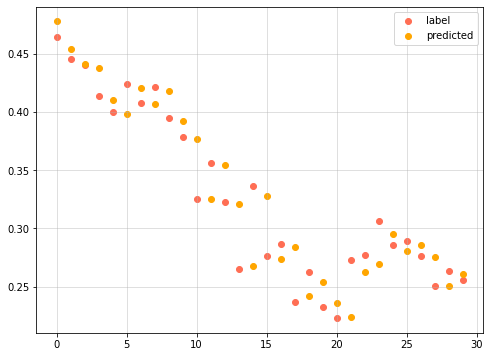

In [100]:
n = 0
x = np.arange(0, time)

plt.scatter(x,label, label='label', color = '#ff6e54')
plt.scatter(x,predicted, label='predicted', color = '#ffa600')
# plt.scatter(x,input_col, label='inputs', color= '#003f5c', alpha=0.5)
plt.grid(alpha=0.5)
plt.legend()

# things to figure out later: 
# why is the shape 4010,7,1 ?
# why are there more values in the predicted resluts than I passed in 

In [101]:
# try:
#   label=label.numpy()
#   input_col = input_col.numpy()
# except:
#   print('already converted')

In [102]:
def return_inverse(dat, input, label, predictions):

  
  print(dat.shape, input.shape, label.shape, predictions.shape)
  
  # unscaled_predictions = scaler.inverse_transform(predictions)
  # unscaled_inputs = scaler.inverse_transform(input)
  # unscaled_labels = scaler.inverse_transform(label)

  # return unscaled_inputs, unscaled_labels, unscaled_predictions

  # reshape in terms of original scale

return_inverse(raw, input_col, label, predicted)

(32, 30, 25) (30,) (30,) (30,)


input shape = (32, 30, 25), label shape = (32, 30, 1), prediction shape = (32, 30, 1)


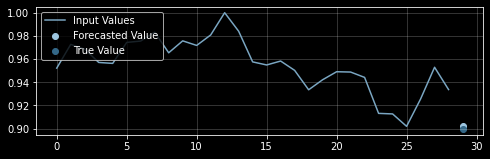

input shape = (32, 30, 25), label shape = (32, 30, 1), prediction shape = (32, 30, 1)


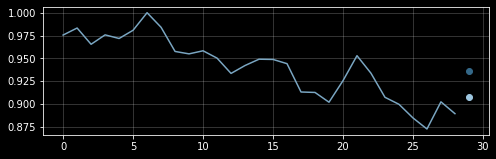

input shape = (32, 30, 25), label shape = (32, 30, 1), prediction shape = (32, 30, 1)


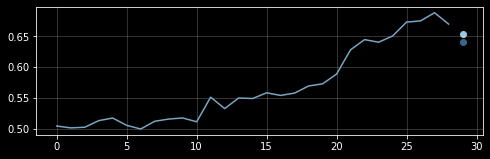

In [103]:
legend = True
with plt.style.context(('dark_background')):
  num = 3

  for i in range(num):
    plt.figure(figsize=(8,8))
    in_, inputs, labels, predictions = gen_data()
    forecast = predictions[-1]
    past = inputs[:-1]
    true_value = labels[-1:]

    plt.subplot(num, 1, i+1)
    plt.plot(x[:-1], past, label = 'Input Values', color= '#7aa6c2')
    plt.scatter(x[-1:],forecast, label = 'Forecasted Value', color='#9dc6e0')
    plt.scatter(x[-1:],true_value, label ='True Value', color='#346888')

    if legend:
      plt.legend(loc=2)
      legend = False
      
    plt.grid(alpha=0.25)
    plt.show()

In [104]:
# figure out how to use ext data to make predictions (ive rough idea) {DONE}
# use 3rd party data from both goldman sachs and another company of around a years worth and check {1/2}
# clean.up.this.code add necessary markdown boxes and stuff [DONE]
# figure out and try out SavedModel datatype [DONE]
